### 一、神经网络的算法思想

人工神经网络(Artificial Neural Networks，简写为ANNs)是一种模仿动物神经网络行为特征，进行**分布式并行信息处理**的算法数学模型。这种网络依靠系统的复杂程度，通过调整内部大量节点之间相互连接的关系，从而达到处理信息的目的，并具有自学习和自适应的能力。

多层前馈神经网络(multi-layer feedforward neural network)。这种特殊类型的网络也称作多层感知器(multi-layer perceptron, MLP)。只含有一个隐藏层的MLP有三个层次的结构：分别是输入层、隐藏层和输出层。可以往三层MLP中加入任意数量的隐层来创建更深层的网络架构。也可以将神经网络的隐层数量看作是一个待优化的超参数。但是应该指出隐层数量的增加会使得通过反向传播算法计算得到的梯度误差也将变得越来越小，及产生梯度消失问题。

神经网络由许多神经元组成，通过相互连接的神经元进行信息的传递和处理。单个神经元的作用是微乎其微的，但是大量的神经元组成的神经网络却具有强大的信息处理能力。

### 二、手写数字的识别

#### 1.读取数据

In [1]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    '''Load MNIST data from ~path~'''
    
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    
    print(labels_path)
    print(images_path)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))   
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [2]:
X_train, y_train = load_mnist('E:\dataset\mnist', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('E:\dataset\mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

E:\dataset\mnist\train-labels.idx1-ubyte
E:\dataset\mnist\train-images.idx3-ubyte
Rows: 60000, columns: 784
E:\dataset\mnist\t10k-labels.idx1-ubyte
E:\dataset\mnist\t10k-images.idx3-ubyte
Rows: 10000, columns: 784


<Figure size 720x576 with 0 Axes>

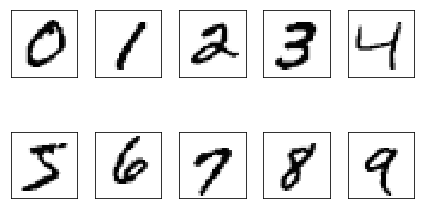

In [4]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

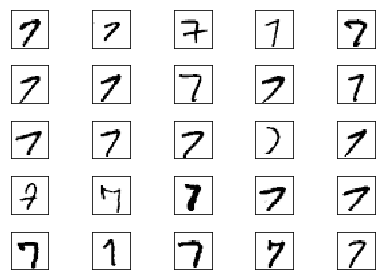

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten() # 矩阵展平成数组
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#### 2.保存为CSV文件并读取

In [59]:
np.savetxt('E:/dataset/mnist/train_img.csv', X_train, fmt='%i', delimiter=',')
np.savetxt('E:/dataset/mnist/train_label.csv', y_train, fmt='%i', delimiter=',')
np.savetxt('E:/dataset/mnist/test_img.csv', X_test, fmt='%i', delimiter=',')
np.savetxt('E:/dataset/mnist/test_label.csv', y_test, fmt='%i', delimiter=',')

In [6]:
X_train = np.genfromtxt('E:/dataset/mnist/train_img.csv', dtype=int, delimiter=',')
y_train = np.genfromtxt('E:/dataset/mnist/train_label.csv', dtype=int, delimiter=',')
X_test = np.genfromtxt('E:/dataset/mnist/test_img.csv', dtype=int, delimiter=',')
y_test = np.genfromtxt('E:/dataset/mnist/test_label.csv', dtype=int, delimiter=',')

#### 3.实现一个多层感知器

In [7]:
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0, l2=0.0, 
                 epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output * (self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
    
    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)
    
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    def _add_bias_unit(self, X, how='column'):
        if how =='column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('~how~ must be ~column~ or ~row~')
        return X_new
    
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_ / 2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
    
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_ / 2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())
    
    def _get_cost(self, y_enc, output, w1, w2):
        term1 =  -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagatio
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        #regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        return grad1, grad2
    
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const * i)
            if print_progress: # 打印出训练的次数，动态显示程序的运行过程
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0]) # 返回打乱的下标
                X_data, y_data = X_data[idx], y_data[idx]
            # 生成batch的数据用于批量随机梯度下降训练模型
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                # compute gradient via backpropagation 
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
                
                # updata weights
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self

初始化一个784-50-10的感知器模型，该神经网络包含784个输入单元(n_features)，50个隐层单元(n_hidden)，以及10个输出单元(n_output)：

In [8]:
'''
l1：L1正则化系数。
l2：L2正则胡系数。
epochs：遍历训练集的次数(迭代次数)。
eta：学习速率η。
alpha：动态学习进度的参数，在上一轮迭代的基础上增加一个因子，用于加快权重更新的学习。
decrease_const：用于降低自适应学习速率的常数。随着迭代次数的增加而随之递减以更好地确保收敛。
shuffle：在每次迭代前打乱训练集的顺序。
Minibatches：在每次迭代中，将训练数据划分为k个小的批次，为了加速学习得过程，梯度由每个批次分别计算，而不是在整个训练集上进行计算。
'''

nn = NeuralNetMLP(n_output=10, n_features=X_train.shape[1], n_hidden=50, l2=0.1, l1=0.0,
                 epochs=200, eta=0.001, alpha=0.001, decrease_const=0.00001, shuffle=True, minibatches=50, random_state=1)

nn.fit(X_train, y_train, print_progress=True)

Epoch: 200/200

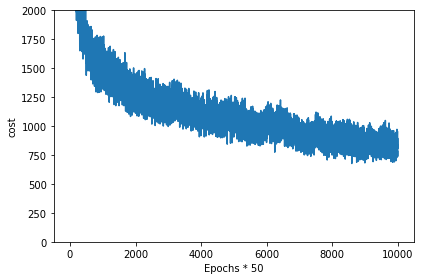

In [10]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

从上图看出，此时的模型并没有全部收敛，因为时间原因只完成了两百次的迭代训练。建议将迭代的次数加到1000次，应该就能得到完全收敛的模型。

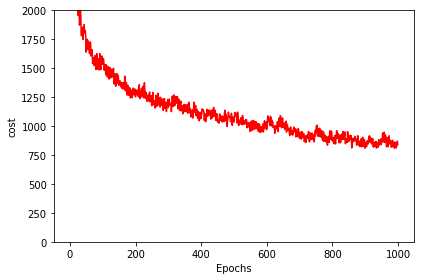

In [11]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [17]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 93.03%


In [19]:
y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 92.82%


模型在训练集与测试集上的精度仅有微小的差异，我们可以推断，模型对于训练数据仅轻微地过拟合。为了进一步对模型进行调优，我们可以改变隐层单元的数量、正则化参数的值、学习速率、衰减常数的值等。

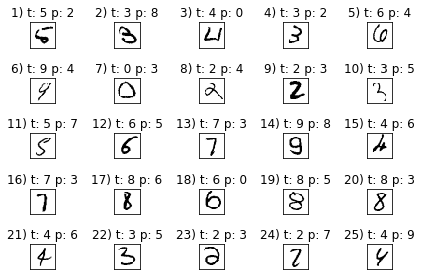

In [28]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img ,cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### 三、人工神经网络的训练

#### 1.梯度检验(检验反向传播算法是否正常工作)

In [54]:
import numpy as np
from scipy.special import expit
import sys

class MLPGradientCheck(object):
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0, l2=0.0, 
                 epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output * (self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
    
    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)
    
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    def _add_bias_unit(self, X, how='column'):
        if how =='column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('~how~ must be ~column~ or ~row~')
        return X_new
    
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_ / 2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
    
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_ / 2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())
    
    def _get_cost(self, y_enc, output, w1, w2):
        term1 =  -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagatio
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        #regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        return grad1, grad2
    
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const * i)
            if print_progress: # 打印出训练的次数，动态显示程序的运行过程
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0]) # 返回打乱的下标
                X_data, y_data = X_data[idx], y_data[idx]
            # 生成batch的数据用于批量随机梯度下降训练模型
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                # compute gradient via backpropagation 
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
                # start gradient checking
                grad_diff = self._gradient_checking(X=X[idx], y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2, epsilon=1e-5, grad1=grad1, grad2=grad2)
                if grad_diff <= 1e-7:
                    print('OK: %s' % grad_diff)
                elif grad_diff <= 1e-4:
                    print('Warning: %s' % grad_diff)
                else:
                    print('PROBLEM: %s' % grad_diff)
                    
                # updata weights
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self
    
    def _gradient_checking(self, X, y_enc, w1, w2, epsilon, grad1, grad2):
        '''Apply gradient checking(for debugging only)
        Returns
        -------
        relatives_error: float
            Relative error between the numerically
            approximately gradients and the backpropagated gradients.
        '''
        
        num_grad1 = np.zeros(np.shape(w1))
        epsilon_ary1 = np.zeros(np.shape(w1))
        for i in range(w1.shape[0]):
            for j in range(w1.shape[1]):
                epsilon_ary1[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X, w1 - epsilon_ary1, w2)
                cost1 = self._get_cost(y_enc, a3, w1 - epsilon_ary1, w2)
                a1, z2, a2, z3, a3 = self._feedforward(X, w1 + epsilon_ary1, w2)
                cost2 = self._get_cost(y_enc, a3, w1 + epsilon_ary1, w2)
                num_grad1[i, j] = (cost2 - cost1) / (2 * epsilon)
                epsilon_ary1[i, j] = 0
                
        num_grad2 = np.zeros(np.shape(w2))
        epsilon_ary2 = np.zeros(np.shape(w2))
        for i in range(w2.shape[0]):
            for j in range(w2.shape[1]):
                epsilon_ary2[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X, w1, w2 - epsilon_ary2)
                cost1 = self._get_cost(y_enc, a3, w1, w2 - epsilon_ary2)
                a1, z2, a2, z3, a3 = self._feedforward(X, w1, w2 + epsilon_ary2)
                cost2 = self._get_cost(y_enc, a3, w1, w2 + epsilon_ary2)
                num_grad2[i, j] = (cost2 - cost1) / (2 * epsilon)
                epsilon_ary2[i, j] = 0
                
        num_grad = np.hstack((num_grad1.flatten(), num_grad2.flatten()))    
        grad = np.hstack((grad1.flatten(), grad2.flatten()))
        norm1 = np.linalg.norm(num_grad - grad)
        norm2 = np.linalg.norm(num_grad)
        norm3 = np.linalg.norm(grad)
        relative_error = norm1 / (norm2 + norm3)
        
        return relative_error                 

In [55]:
nn_check = MLPGradientCheck(n_output=10, n_features=X_train.shape[1], n_hidden=10, l2=0.0, l1=0.0, epochs=10, eta=0.001, alpha=0.0, decrease_const=0.0, minibatches=1, random_state=1)

In [56]:
nn_check.fit(X_train[:5], y_train[:5], print_progress=False)

OK: 2.547178604857207e-10
OK: 3.1055945830621735e-10
OK: 2.381983188561259e-10
OK: 3.036785198608931e-10
OK: 3.368345140751822e-10
OK: 3.5875948399767924e-10
OK: 2.198885901516091e-10
OK: 2.337387773884223e-10
OK: 3.287636609571923e-10
OK: 2.1363722298076513e-10


注：通过计算数值梯度与解析梯度的相对误差来检验反向传播算法是否正常工作。公式如下：

$$
\frac{\partial}{\partial w_{i, j}^{(l)}} J(\boldsymbol{W}) \approx \frac{J\left(w_{i, j}^{(l)}+\varepsilon\right)-J\left(w_{i, j}^{(l)}\right)}{\varepsilon}
$$

此处的数值梯度(式子右边)是用损失函数的导数差分定义式求出的，而解析梯度(式子左边)是根据损失函数推导得到的解析式求得的。故通过计算两者的相对误差的方法，可以检验反向传播算法是否正常工作。

### 四、神经网络的收敛性

传统的梯度下降算法是在整个训练集上更新权重的，而在线学习中使用的随机梯度下降，每次仅使用一个训练样本(k=1)来更新权重。我们在上述神经网络的训练中，使用的是批量梯度下降的训练方法，把训练集划分为一定数量的小批次，每次输入一个批次的样本来对模型进行训练。这样做的意义在于能够将数据以矩阵的形式组合起来计算和传递，从而加快神经网络的训练。

通常神经网络的代价函数曲线并不平滑，容易陷入局部最优解。神经网络的学习率可以看作是权值更新的尺度，决定着权值更新的快慢。为了避免陷入局部最优解，可以定义一个较大的学习速率，让算法跳过局部最优，并且能够很快到达全局最优的位置。但是学习率过大的话，很有可能让算法跳出全局最优点。一个解决办法是让学习率随着神经网络的训练而逐渐变小，在前面的训练阶段，较大的学习率可以让算法快速到到达全局最优点，并且跳过一些局部最优解。而在训练的后期阶段，较小的学习率能帮助我们更好的到底全局最优。

### 五、其他神经网络

#### 1.卷积神经网络(CNN)

卷积神经网络(Convolutional Neural Network, CNN)可以看作是在MLP前面加入许多层特征检测器得到的模型。前面的卷积层用于提取特征，池化层用于减少计算量和防止过拟合，而最后的MLP则用于特征整合和数据分类。CNN的灵感来源于动物视觉皮层的神经活动机理，研究人员们从中提炼出了一个很有意思的"局部感受"的工作模式，并将其用于图像特征的提取。

#### 2.循环神经网络(RNN)

可理解为包含于时间相关的反馈循环或者反向传播的前馈神经网络。从本质上看，我们可以将循环神经网络看作是包含着额外时间变量的多层感知器。由于具备着时间属性和自身的动态结构。使得网络不光能接受当前输入值，还可以接受此前的其他输入。

尽管循环神经网络在语音识别、语言翻译，以及手写识别等领域成效显著，不过这种网络架构训练起来却相当困难。这是因为我们不能简单地将错误逐层反向传播，而必须考虑到时间维度，它放大了梯度消失与梯度爆炸的问题。在1997年，Juergen Schmidhuber和他同事提出了所谓的长短时记忆（long short-term memory）单元来解决此问题。

总结：本篇笔记中涉及到多层人工神经网络中最重要的一些概念，探讨了时下流行的反向传播算法，它是众多神经网络模型的基石之一。在学习了反向传播算法后，通过对权重更新的实践完成了对神经网络的训练。其中，也做了一些有益的修改，例如加入子批次学习和自适应学习速率等，以更高效地训练神经网络。

后记：本篇笔记是《python机器学习》系列笔记的最后一篇，前前后后看了近一个月，终于把这本书啃完。总体来说，这本书是一本绝佳的机器学习的入门级教材，书里省去了大量的数学推导，而把焦点放在了机器学习算法的代码实现上，从代码层面辅以一些必要的数学公式让初学者迅速掌握机器学习的重要概念。由于笔者代码能力较弱，没有利用python进行编程的经验，所以在学这本书的时候及其不顺利。经过了这一个多月的学习，笔者也深刻意识到熟练掌握一门编程语言以及培养自己的算法思维是每一个程序员必备的功课。而对于机器学习这个领域，从本质来说就是对隐藏在数据里的线性或者非线性关系进行挖掘和学习。这是一门交叉学科，不仅要学习怎么在工程上实现一个机器学习模型，而且要理解和掌握算法中涉及到的微积分、线性代数以及统计学理论等数学知识。当然，我们的目的不是成为一个数学家，对里面深奥的数学知识不需要去深挖和研究，但是必要的数学知识一定要具备，最起码的是要懂得如何从工程实现的角度去理解数学，这是一名合格的计算机工程师应该具备的。在以后的学习中，笔者将跟着斯坦福大学的系列课程继续深入地学习机器学习，与此同时，还应该力求熟练掌握python语言，在学有余力的同时还应当学习数据结构与算法的相关知识。